<a href="https://colab.research.google.com/github/Ousmane145/ojs/blob/main/Challenge_ForceN_Classification_sentiment_Dialecte_Tunisie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Développement d'un modèle d'apprentissage automatique pour évaluer si une publication Twitter relative aux vaccinations est positive, neutre ou négative**


##**1. Installation  et Importation des librairies**

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn torch transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##**2. Charger les donnees**

In [6]:
df = pd.read_csv("Train.csv")  # adapte le nom si besoin



##**3. Exploration des donnees**

In [7]:
df.head()

,ID,text,label
0,ID_13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1
1,ID_SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1
2,ID_V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1
3,ID_U0TTYY8,ak slouma,1
4,ID_68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1


In [8]:
df.tail()

,ID,text,label
69995,ID_ZRSR7TZ,pff bayna beli kbira f wejhakk yakhiii rouhi r...,-1
69996,ID_QNQVEIH,aman lmara jeya zidou t3am9ou fel a7deeth akth...,-1
69997,ID_LJ2K9MD,winha nakhtabha hhhhh,-1
69998,ID_5RZ1T7I,fachel enta w houwa,-1
69999,ID_WZCF7CL,nchla lyouma nesm3ou a5beer bahiya 3la jem3iya,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70000 non-null  object
 1   text    70000 non-null  object
 2   label   70000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [10]:
df['label'].value_counts()


,count
label,
1,38239
-1,29295
0,2466


In [11]:
# Gérer les valeurs NaN et supprimer la valeur 0.666667, puis encoder les labels

# Supprimer les lignes où 'label' est NaN
df.dropna(subset=['label'], inplace=True)

# Afficher la nouvelle distribution des labels pour vérification
print(df['label'].value_counts())

label
 1    38239
-1    29295
 0     2466
Name: count, dtype: int64


In [ ]:
print(sorted(df['label'].unique()))


[np.int64(0), np.int64(1), np.int64(2)]


In [12]:
df.shape

(70000, 3)

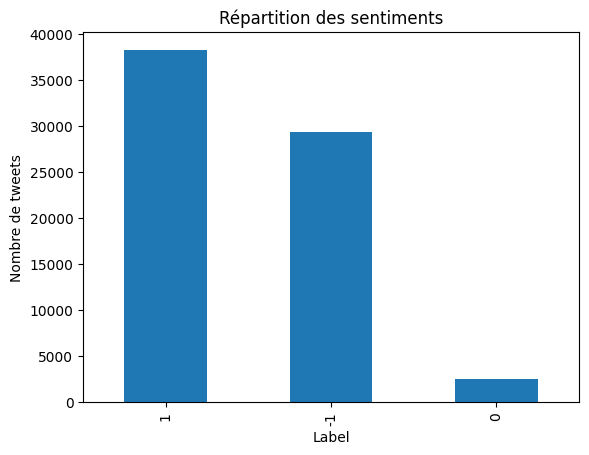

In [13]:
import matplotlib.pyplot as plt

sentiment_counts = df['label'].value_counts()

plt.figure()
sentiment_counts.plot(kind='bar')
plt.title("Répartition des sentiments")
plt.xlabel("Label")
plt.ylabel("Nombre de tweets")
plt.show()


In [14]:
df['tweet_length'] = df['text'].apply(len)


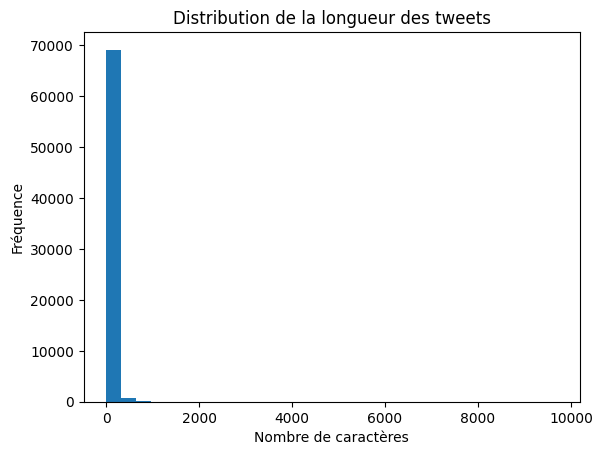

In [15]:
plt.figure()
plt.hist(df['tweet_length'], bins=30)
plt.title("Distribution de la longueur des tweets")
plt.xlabel("Nombre de caractères")
plt.ylabel("Fréquence")
plt.show()


In [16]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))


<Figure size 640x480 with 0 Axes>

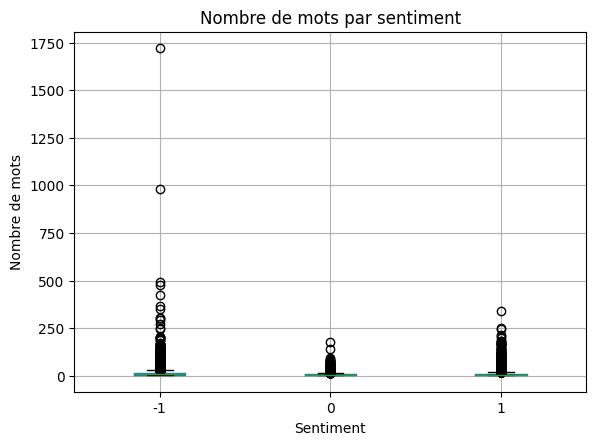

In [17]:
plt.figure()
df.boxplot(column='word_count', by='label')
plt.title("Nombre de mots par sentiment")
plt.suptitle("")
plt.xlabel("Sentiment")
plt.ylabel("Nombre de mots")
plt.show()


##**4. Pre-Traitement des donnees**

In [18]:
#les stop_words
import re
from nltk.corpus import stopwords
import nltk

arabizi_stopwords = {
    "ena","enti","houa","hiya","ahna","homma",
    "fi","f","fel","3la","ala","m3a","men","min",
    "w","ya","elli","lli",
    "user","url"
}

In [19]:
#Nettoyage leger pour l'analyse textuelle
def clean_for_bert(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"(.)\1{2,}", r"\1", text)  # répétitions
    text = re.sub(r"[^a-z0-9\s]", " ", text) # ⚠️ chiffres conservés

    tokens = text.split()
    tokens = [t for t in tokens if t not in arabizi_stopwords]

    return " ".join(tokens)
df['text'] = df['text'].fillna('').astype(str)
df['clean_text'] = df['text'].apply(clean_for_bert)

In [21]:
#Mots les plus frequents
from collections import Counter

all_words = " ".join(df['clean_text']).split()
word_freq = Counter(all_words)

most_common_words = word_freq.most_common(20)


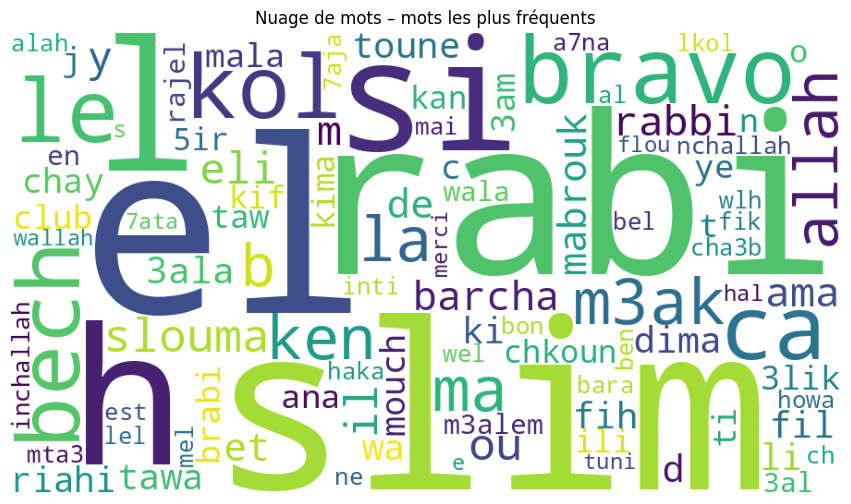

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Texte global à partir des tweets nettoyés
text = " ".join(df['clean_text'].dropna())

# Création du WordCloud
wordcloud = WordCloud(
    width=900,
    height=500,
    background_color='white',
    max_words=100,
    collocations=False
).generate(text)

# Affichage
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Nuage de mots – mots les plus fréquents")
plt.show()



In [23]:
#Encodage des labels
label_encoder = LabelEncoder()
df['label_enc'] = label_encoder.fit_transform(df['label'])

num_labels = len(label_encoder.classes_)
print("Labels :", label_encoder.classes_)


Labels : [-1  0  1]


In [24]:
#Split train / validation
traitrain_texts, val_texts, train_labels, val_labels = train_test_split(
    df['clean_text'],
    df['label_enc'],
    test_size=0.2,
    random_state=42,
    stratify=df['label_enc']
)

In [25]:
#Charger le tokenizer
tokenizer = BertTokenizer.from_pretrained(
    "bert-base-multilingual-cased"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [26]:
#Dataset personnalise
class ZindiDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [29]:
#Creation du dataset et DataLoader
train_dataset = ZindiDataset(traitrain_texts, train_labels, tokenizer)
val_dataset   = ZindiDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)


In [30]:
#Charger le modele
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_labels
)

model.to(device)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [31]:
print(sorted(df['label'].unique()))


[np.int64(-1), np.int64(0), np.int64(1)]


In [32]:
#Optimiseur
optimizer = AdamW(model.parameters(), lr=2e-5)

In [33]:
#Fonction d'Evaluation
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            y = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            logits = outputs.logits
            p = torch.argmax(logits, dim=1)

            preds.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return (
        accuracy_score(labels, preds),
        precision_score(labels, preds, average='weighted'),
        recall_score(labels, preds, average='weighted'),
        f1_score(labels, preds, average='weighted')
    )

In [34]:
#Entrainement
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in loop:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    acc, prec, rec, f1 = evaluate(model, val_loader)

    print(f"\nEpoch {epoch+1}")
    print(f"Loss : {total_loss/len(train_loader):.4f}")
    print(f"Acc  : {acc:.4f} | F1 : {f1:.4f}")

Epoch 1/3: 100%|██████████| 3500/3500 [22:13<00:00,  2.63it/s, loss=0.358]



Epoch 1
Loss : 0.5505
Acc  : 0.7954 | F1 : 0.7950


Epoch 2/3: 100%|██████████| 3500/3500 [22:13<00:00,  2.62it/s, loss=0.244]



Epoch 2
Loss : 0.4152
Acc  : 0.8108 | F1 : 0.8111


Epoch 3/3: 100%|██████████| 3500/3500 [22:14<00:00,  2.62it/s, loss=0.17]



Epoch 3
Loss : 0.3244
Acc  : 0.8101 | F1 : 0.8074


In [36]:
#Tester le model
test_df = pd.read_csv("Test.csv")
test_df['text'] = test_df['text'].fillna('').astype(str)
test_df['clean_text'] = test_df['text'].apply(clean_for_bert)

model.eval()
preds = []

for text in tqdm(test_df['clean_text'], desc="Prediction"):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()

    preds.append(pred)


Prediction: 100%|██████████| 30000/30000 [04:13<00:00, 118.40it/s]


In [40]:
#Generation du fichier submission
test_df['label'] = label_encoder.inverse_transform(preds)

submission = test_df[['ID', 'label']]
submission.to_csv("submission.csv", index=False)

print("✅ submission.csv généré avec succès")


✅ submission.csv généré avec succès
